# Lyft Perception Challenge

## Challenge Overview

Your goal in this challenge is pixel-wise identification of objects in camera images. In other words, your task is to identify exactly what is in each pixel of an image! More specifically, you'll be identifying cars and the drivable area of the road. The images below are a simulated camera image on the left and a label image on the right, where each different type of object in the image corresponds to a different color.

![Example image and pixel-wise labels](overview.png)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Data Exploration

For this challenge you will train your perception algorithm using data from the [CARLA](http://carla.org/) simulator. You can download the data [here](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/Lyft_Challenge/Training+Data/lyft_training_data.tar.gz). The dataset consists of images and the corresponding ground truth pixel-wise labels for each image.

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [3]:
PATH = 'data/'

In [4]:
os.listdir(PATH)

['CameraRGB', 'CameraSeg', 'vgg']

In [5]:
images = os.listdir(f'{PATH}CameraRGB')[:5]
labels = os.listdir(f'{PATH}CameraSeg')[:5]

In [6]:
sample_img = plt.imread(f'{PATH}CameraRGB/{images[0]}', format='PNG')
label_img = plt.imread(f'{PATH}CameraSeg/{labels[0]}', format='PNG')

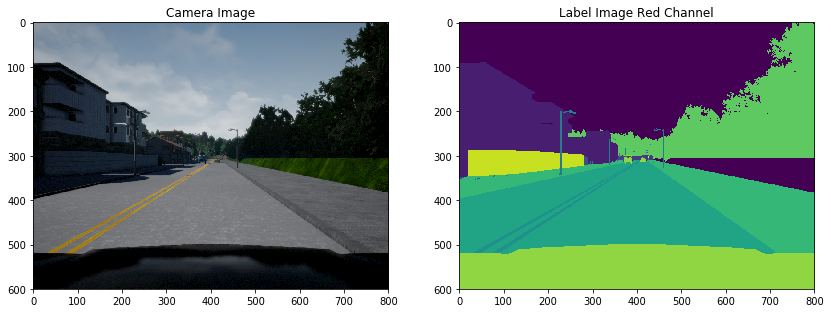

In [7]:
plt.figure(figsize=(14,12))
plt.subplot(121)
plt.title("Camera Image")
plt.imshow(sample_img)
plt.subplot(122)
plt.title("Label Image Red Channel")
plt.imshow(label_img[:,:,0])

## Preprocessing Ground Truth Labels

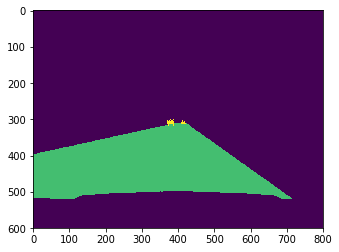

In [8]:
def preprocess(img):
    res = np.copy(img)
    # lane to road
    res[res==6] = 7
    # set all zero except road and vehicle
    res[(res!=7)&(res!=10)] = 0
    # Hood to zero
    res[490:,:,:][res[490:,:,:]==10] = 0
    return res

plt.imshow(preprocess(label_img)[:,:,0])

## Training

In [20]:
import tensorflow as tf
import imageio
import scipy.misc
from glob import glob
import random

In [21]:
def gen_batch_function(data_folder, image_shape):
    def get_batches_fn(batch_size):
        image_paths = glob(os.path.join(data_folder, 'CameraRGB', '*.png'))
        label_paths = {
            os.path.basename(path): path
            for path in glob(os.path.join(data_folder, 'CameraSeg', '*.png'))
        }
        background_color = np.array([255, 0, 0])

        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = scipy.misc.imresize(imageio.imread(image_file), image_shape)
                gt_image = scipy.misc.imresize(imageio.imread(gt_image_file), image_shape)

                gt_bg = np.all(gt_image == background_color, axis=2)
                gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn

In [11]:
def load_vgg(sess, vgg_path):
  vgg_tag = 'vgg16'
  vgg_input_tensor_name = 'image_input:0'
  vgg_keep_prob_tensor_name = 'keep_prob:0'
  vgg_layer3_out_tensor_name = 'layer3_out:0'
  vgg_layer4_out_tensor_name = 'layer4_out:0'
  vgg_layer7_out_tensor_name = 'layer7_out:0'

  tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
  graph = tf.get_default_graph()
  image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
  keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
  layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
  layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
  layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
  
  return image_input, keep_prob, layer3_out, layer4_out, layer7_out

In [12]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
  he_init = tf.contrib.layers.variance_scaling_initializer()
  l2_regularizer = tf.contrib.layers.l2_regularizer(1e-3)

  # Add the 1x1 layers
  l7 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, padding='same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
  l4 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, padding='same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
  l3 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, padding='same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
  # Upsampling
  out = tf.layers.conv2d_transpose(l7, num_classes, 4, 2, 'same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
  # Skip-layer + upsampling
  out = tf.add(out, l4)
  out = tf.layers.conv2d_transpose(out, num_classes, 4, 2, 'same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
  # Skip-layer + upsampling
  out = tf.add(out, l3)
  out = tf.layers.conv2d_transpose(out, num_classes, 16, 8, 'same', kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
  
  return out

In [13]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
  logits = tf.reshape(nn_last_layer, (-1, num_classes))
  correct_label = tf.reshape(correct_label, (-1,num_classes))

  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=correct_label))
  train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)
  return logits, train_op, cross_entropy_loss

In [14]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
  print("Training start...")
  for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch+1, epochs))
    for batch, (images, labels) in enumerate(get_batches_fn(batch_size)):
      feed_dict = {input_image: images, correct_label: labels, keep_prob: 0.5, learning_rate: 1e-5}
      _, loss = sess.run([train_op, cross_entropy_loss], feed_dict=feed_dict)
      print("  Batch: {}, Training Loss: {:.4f}".format(batch+1, loss))

In [22]:
num_classes = 3
image_shape = (300, 400)
data_dir = './data'

# Download pretrained vgg model
# helper.maybe_download_pretrained_vgg(data_dir)

with tf.Session() as sess:
    # Path to vgg model
    vgg_path = os.path.join(data_dir, 'vgg')
    # Create function to get batches
    get_batches_fn = gen_batch_function(data_dir, image_shape)

    # OPTIONAL: Augment Images for better results
    #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

    # Build NN using load_vgg, layers, and optimize function
    epochs = 6
    batch_size = 2
    correct_label = tf.placeholder(tf.float32, [None, None, None, num_classes])
    learning_rate = tf.placeholder(tf.float32)

    image_input, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
    model = layers(layer3_out, layer4_out, layer7_out, num_classes)
    logits, train_op, cross_entropy_loss = optimize(model, correct_label, learning_rate, num_classes)    
    # Train NN using the train_nn function
    sess.run(tf.global_variables_initializer())
    train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, image_input, correct_label, keep_prob, learning_rate)

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'


ValueError: GraphDef cannot be larger than 2GB.